## Dataset Inspection

In [2]:
import json
from collections import defaultdict

def analyze_coco_dataset(ann_file):
    # Load COCO annotations
    with open(ann_file, "r") as f:
        coco = json.load(f)

    # Build category mapping
    categories = {cat["id"]: cat["name"] for cat in coco["categories"]}

    # Track images per class
    class_to_images = defaultdict(set)  # use set to avoid double counting
    for ann in coco["annotations"]:
        class_id = ann["category_id"]
        image_id = ann["image_id"]
        class_to_images[class_id].add(image_id)

    # Print summary
    print("Categories in dataset:")
    for class_id, class_name in categories.items():
        num_images = len(class_to_images[class_id])
        print(f"ID: {class_id}, Name: {class_name}, Images: {num_images}")

    print("\nTotal categories:", len(categories))
    print("Total images:", len(coco["images"]))

ann_file = r"data\vehicle_dataset\train\_annotations.coco.json"
analyze_coco_dataset(ann_file)

Categories in dataset:
ID: 0, Name: bus, Images: 3960
ID: 1, Name: car, Images: 3930
ID: 2, Name: truck, Images: 3903
ID: 3, Name: van, Images: 3939
ID: 4, Name: motorcycle, Images: 3876

Total categories: 5
Total images: 19656


## Fine-tune Model

In [ ]:
import supervision as sv
from rfdetr import RFDETRMedium  
from IPython.utils.io import Tee
import os

# Make sure the output directory exists
os.makedirs(r"data\vehicle_dataset_training_output", exist_ok=True)

model = RFDETRMedium()

# Start logging
tee = Tee(r"data\vehicle_dataset_training_output\training_log.txt", "w", channel="stdout")

# Train
results = model.train(
    dataset_dir=r"data\vehicle_dataset",
    epochs=100,                # train longer, but watch val mAP
    batch_size=4,              # fits in 8GB
    grad_accum_steps=4,        # effective batch = 16
    lr=1e-4,                   
    output_dir=r"data\vehicle_dataset_training_output",
    resume=r"data\vehicle_dataset_training_output\checkpoint.pth"
)

# Stop logging
tee.close()


## Visualize Mean Average Precision

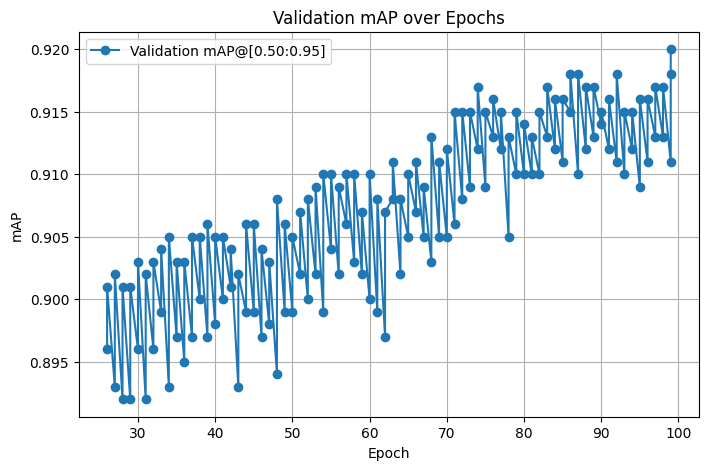

In [1]:
import re
import matplotlib.pyplot as plt

# Path to your training log
log_file = r"data\vehicle_dataset_training_output\training_log.txt"

# Regex to capture AP@[0.50:0.95 | area=all]
map_pattern = re.compile(
    r"Average Precision\s+\(AP\)\s+@\[\s*IoU=0\.50:0\.95\s*\|\s*area=\s*all\s*\|\s*maxDets=100\s*\]\s*=\s*([\d\.]+)"
)

epochs = []
maps = []
epoch = -1

with open(log_file, "r") as f:
    for line in f:
        # Detect epoch number
        match_epoch = re.search(r"Epoch:\s*\[(\d+)\]", line)
        if match_epoch:
            epoch = int(match_epoch.group(1))
        
        # Detect validation AP
        match_map = map_pattern.search(line)
        if match_map and epoch >= 0:
            ap = float(match_map.group(1))
            epochs.append(epoch)
            maps.append(ap)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, maps, marker="o", linestyle="-", label="Validation mAP@[0.50:0.95]")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title("Validation mAP over Epochs")
plt.legend()
plt.grid(True)
plt.show()

## Visualize Mean Average Precision By Object Size

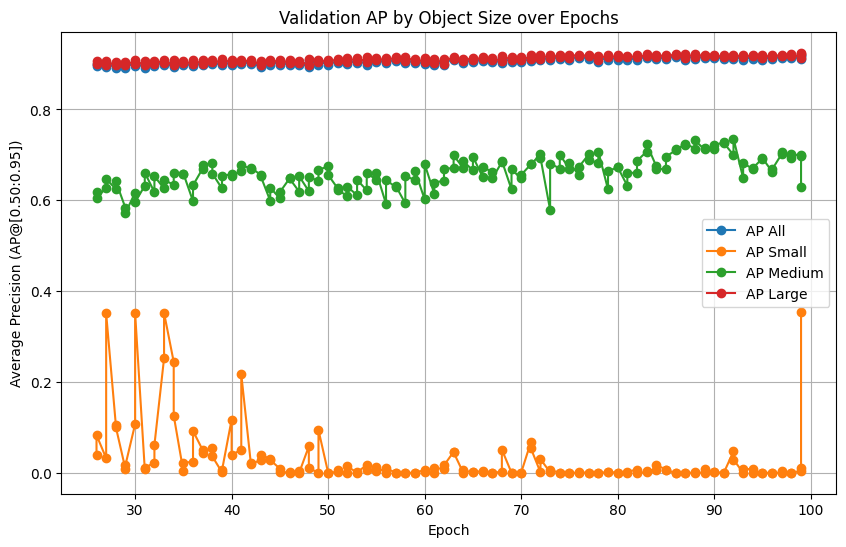

In [4]:
import re
import matplotlib.pyplot as plt

log_file = r"data\vehicle_dataset_training_output\training_log.txt"

# Regex for size-based AP
map_all = re.compile(r"AP.*IoU=0\.50:0\.95.*area=\s*all.*=\s*([\d\.]+)")
map_small = re.compile(r"AP.*IoU=0\.50:0\.95.*area=\s*small.*=\s*([\d\.]+)")
map_medium = re.compile(r"AP.*IoU=0\.50:0\.95.*area=\s*medium.*=\s*([\d\.]+)")
map_large = re.compile(r"AP.*IoU=0\.50:0\.95.*area=\s*large.*=\s*([\d\.]+)")

epoch_pattern = re.compile(r"Epoch:\s*\[(\d+)\]")

epochs, ap_all, ap_small, ap_medium, ap_large = [], [], [], [], []
epoch = -1

with open(log_file, "r") as f:
    for line in f:
        match_epoch = epoch_pattern.search(line)
        if match_epoch:
            epoch = int(match_epoch.group(1))

        if "Average Precision" in line:
            if map_all.search(line):
                ap_all.append(float(map_all.search(line).group(1)))
                epochs.append(epoch)
            elif map_small.search(line):
                ap_small.append(float(map_small.search(line).group(1)))
            elif map_medium.search(line):
                ap_medium.append(float(map_medium.search(line).group(1)))
            elif map_large.search(line):
                ap_large.append(float(map_large.search(line).group(1)))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, ap_all, marker="o", label="AP All")
plt.plot(epochs, ap_small, marker="o", label="AP Small")
plt.plot(epochs, ap_medium, marker="o", label="AP Medium")
plt.plot(epochs, ap_large, marker="o", label="AP Large")

plt.xlabel("Epoch")
plt.ylabel("Average Precision (AP@[0.50:0.95])")
plt.title("Validation AP by Object Size over Epochs")
plt.legend()
plt.grid(True)
plt.show()